# Obtaining robust cell population markers, and redefining/reassuring the biased cell populations

## imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np
import os
import triku as tk
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import scipy.sparse as spr
import matplotlib.cm as cm
import networkx as nx

In [3]:
!pip install cellassign

In [4]:
# local imports and imports from other notebooks
from cellassign import assign_cats
from fb_functions import make_gene_scoring_with_expr, plot_score_graph, plot_UMAPS_gene, plot_adata_cluster_properties
%store -r dict_colors
%store -r seed
%store -r magma
%store -r data_dir

In [5]:
mpl.rcParams['figure.dpi'] = 120
pd.options.display.float_format = "{:,.2f}".format

**IMPORTANT: I am running this analysis in a computer with ~500 GB of RAM. I will load many datasets at once, which might be too much for some computers. I took this decision conciously, to have as much info available at any time as possible. If you cannot run all the analysis at once, you can run it by parts.**

## Anndata loading

In [6]:
ahlers_2022_dir = data_dir + '/ahlers_2022'
ahlers_2022_young_fb = sc.read(ahlers_2022_dir + '/ahlers_2022_young_fb_processed.h5')

In [7]:
boothby_2021_dir = data_dir + '/boothby_2021'
boothby_2021_ctrl_fb = sc.read(boothby_2021_dir + '/boothby_2021_ctrl_fb_processed.h5')

In [8]:
deng_2021_dir = data_dir + '/deng_2021'
deng_2021_scar_fb = sc.read(deng_2021_dir + '/deng_2021_scar_fb_processed.h5')

In [9]:
gao_2021_dir = data_dir + '/gao_2021'
gao_2021_ctrl_fb = sc.read(gao_2021_dir + '/gao_2021_ctrl_fb_processed.h5')

In [10]:
gaydosik_2020_dir = data_dir + '/gaydosik_2020'
gaydosik_2020_ctrl_fb = sc.read(gaydosik_2020_dir + '/gaydosik_2020_ctrl_fb_processed.h5')

In [11]:
he_2020_dir = data_dir + '/He_2020'
he_2020_ctrl_fb = sc.read(he_2020_dir + '/he_2020_ctrl_fb_processed.h5')

In [12]:
hughes_2020_dir = data_dir + '/hughes_2020'
hughes_2020_ctrl_fb = sc.read(hughes_2020_dir + '/hughes_2020_ctrl_fb_processed.h5')

In [13]:
kim_2020_dir = data_dir + '/Kim_2020'
kim_2020_ctrl_fb = sc.read(kim_2020_dir + '/kim_2020_ctrl_fb_processed.h5')

In [14]:
kim_2021_dir = data_dir + '/kim_2021'
kim_2021_ctrl_fb = sc.read(kim_2021_dir + '/kim_2021_ctrl_fb_processed.h5')

In [15]:
liu_2021_dir = data_dir + '/liu_2021'
liu_2021_ctrl_fb = sc.read(liu_2021_dir + '/liu_2021_ctrl_fb_processed.h5')

In [16]:
mariottoni_2021_dir = data_dir + '/mariottoni_2021'
mariottoni_2021_ctrl_fb = sc.read(mariottoni_2021_dir + '/mariottoni_2021_ctrl_fb_processed.h5')

In [17]:
mirizio_2020_dir = data_dir + '/mirizio_2020'
mirizio_2020_scl_fb = sc.read(mirizio_2020_dir + '/mirizio_2020_scl_2020_fb_processed.h5')

In [18]:
reynolds_2021_dir = data_dir + '/reynolds_2021'
reynolds_2021_ctrl_fb = sc.read(reynolds_2021_dir + '/reynolds_2021_ctrl_fb_processed.h5')

In [19]:
rindler_2021_dir = data_dir + '/rindler_2021'
rindler_2021_ctrl_fb = sc.read(rindler_2021_dir + '/rindler_2021_ctrl_fb_processed.h5')

In [20]:
sole_2020_dir = data_dir + '/Sole-Boldo_2020'
sole_2020_young_fb = sc.read(sole_2020_dir + '/sole_2020_young_fb_processed.h5')

In [21]:
tabib_2018_dir = data_dir + '/Tabib_2018'
tabib_2018_ctrl_fb = sc.read(tabib_2018_dir + '/tabib_2018_ctrl_2018_fb_processed.h5')

In [22]:
tabib_2021_dir = data_dir + '/Tabib_2021'
tabib_2021_ctrl_fb = sc.read(tabib_2021_dir + '/tabib_2021_ctrl_fb_processed.h5')

In [23]:
theo_2020_dir = data_dir + '/Theocharidis_2020/'
theo_2020_ctrl_dm_fb = sc.read(theo_2020_dir + '/theo_2020_ctrl_dm_fb_processed.h5')

In [24]:
theo_2021_dir = data_dir + '/Theocharidis_2021/'
theo_2021_ctrl_fb = sc.read(theo_2021_dir + '/theo_2021_ctrl_fb_processed.h5')

In [25]:
vors_2020_dir = data_dir + '/Vorstandlechner_2020'
vors_2020_ctrl_fb = sc.read(vors_2020_dir + '/vors_2020_ctrl_fb_2020_processed.h5')

In [26]:
xu_2021_dir = data_dir + '/xu_2021'
xu_2021_ctrl_fb = sc.read(xu_2021_dir + '/xu_2021_ctrl_fb_processed.h5')

## Evaluate marker score for adatas
All the **commented anndatas are discarded** for marker selection because they do not show enough marker consistency and might bias the result, or because they belong to dataset from non control/healthy conditions.

In [27]:
list_datasets = [
                 ahlers_2022_young_fb,
#                  boothby_2021_ctrl_fb,
#                  deng_2021_scar_fb, 
                 gao_2021_ctrl_fb, 
                 gaydosik_2020_ctrl_fb, 
#                  he_2020_ctrl_fb, 
#                  hughes_2020_ctrl_fb, 
                 kim_2020_ctrl_fb, 
                 liu_2021_ctrl_fb, 
                 mariottoni_2021_ctrl_fb,
                 mirizio_2020_scl_fb, 
#                  reynolds_2021_ctrl_fb,
                 rindler_2021_ctrl_fb,
                 sole_2020_young_fb, 
                 tabib_2018_ctrl_fb, 
                 tabib_2021_ctrl_fb,
                 theo_2020_ctrl_dm_fb, 
#                  theo_2021_ctrl_fb,
                 vors_2020_ctrl_fb, 
                 xu_2021_ctrl_fb
                    ]

list_accepted_clusters = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C5', 'D1', 'D2', 'E1', 'T1',]                
list_accepted_axis = ['A', 'B', 'C', 'D', 'E']

# manual_axis is to create a robust set of markers
for adata in list_datasets:
    adata.obs['manual_axis'] = [i[0] for i in adata.obs['cluster']]

In [28]:
dict_make_gene_scoring = make_gene_scoring_with_expr(list_datasets=list_datasets, calculate_DEGs = True, group_name = 'cluster', value_ref = 'scores', select_method = 'pval', 
                                                     select_thres = 0.05, list_clusters=list_accepted_clusters)

... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical
... storing 'manual_axis' as categorical


In [29]:
dict_make_gene_scoring_axis = make_gene_scoring_with_expr(list_datasets=list_datasets, calculate_DEGs = True, group_name = 'manual_axis', list_clusters=['A', 'B', 'C', 'D', 'E'],
                                                     value_ref = 'scores', select_method = 'pval', select_thres = 0.05)

## Recalculating clusters in the datasets

In [30]:
dict_cats_clusters_robust = {i: np.array(dict_make_gene_scoring[i].index[:30]) for i in dict_make_gene_scoring.keys()}
dict_cats_axes_robust = {i: np.array(dict_make_gene_scoring_axis[i].index[:30]) for i in dict_make_gene_scoring_axis.keys()}

In [31]:
dict_cats_clusters_robust

{'A1': array(['WISP2', 'PI16', 'FBLN1', 'SLPI', 'CTHRC1', 'MFAP5', 'MATN4',
        'SEMA3B', 'MMP2', 'PDGFRL', 'CPVL', 'CD55', 'TSPAN8', 'DCN',
        'FAM180B', 'CHRDL1', 'QPCT', 'SEMA3C', 'DPP4', 'FBLN2', 'PIEZO2',
        'AEBP1', 'ANGPTL5', 'TNXB', 'CCN5', 'SCARA5', 'PRKG2', 'CTSK',
        'GALNT15', 'LOX'], dtype=object),
 'A2': array(['COL18A1', 'CLEC2A', 'NKD2', 'COL23A1', 'APCDD1', 'COL13A1',
        'NPTX2', 'HSPB3', 'COL6A1', 'COMP', 'COL6A5', 'F13A1', 'PHACTR3',
        'STC2', 'TMEM52', 'AXIN2', 'PTGS1', 'C1orf198', 'AKAP6', 'CYP26B1',
        'ROBO2', 'RSPO1', 'TNFRSF19', 'LEPR', 'TGFBI', 'LINC00327', 'STC1',
        'SFRP2', 'COL6A2', 'THSD4'], dtype=object),
 'A3': array(['WIF1', 'FBLN1', 'QPCT', 'SFRP2', 'MMP2', 'WISP2', 'C1QTNF3',
        'DCN', 'SGCA', 'CTHRC1', 'CORIN', 'COL1A2', 'SPARC', 'ELN', 'CES1',
        'COL3A1', 'CTSK', 'BGN', 'CPE', 'ANGPTL5', 'PPIC', 'THBS2',
        'SOSTDC1', 'PI16', 'CD9', 'AEBP1', 'NBL1', 'PDGFRL', 'DPP4', 'XG'],
       dtype=object

In [32]:
dict_cats_axes_robust

{'A': array(['MMP2', 'SFRP2', 'NBL1', 'DPP4', 'WIF1', 'QPCT', 'COL1A2',
        'C1QTNF3', 'COL3A1', 'SPARC', 'CTHRC1', 'AQP1', 'ELN', 'WISP2',
        'CD9', 'PCOLCE2', 'SGCA', 'PTGIS', 'FBN1', 'COL14A1', 'LEPR',
        'SLPI', 'COL6A2', 'CLEC2A', 'THBS2', 'PPIC', 'COL5A1', 'COL6A1',
        'PAM', 'MATN4'], dtype=object),
 'B': array(['APOE', 'GGT5', 'CYGB', 'CXCL12', 'C7', 'C3', 'RBP5', 'APOC1',
        'TNFSF13B', 'CCL19', 'IRF8', 'IGFBP7', 'CXCL2', 'IL33', 'RARRES2',
        'SCN4B', 'EFEMP1', 'CXCL3', 'CCL2', 'SOD2', 'MSC', 'TNFSF14',
        'TMEM176A', 'ICAM1', 'GEM', 'C1orf54', 'CLSTN3', 'PPDPFL', 'MYOC',
        'CCDC146'], dtype=object),
 'C': array(['TNN', 'ASPN', 'COL11A1', 'TNMD', 'COCH', 'PPP1R14A', 'EDNRA',
        'KIF26B', 'CRABP1', 'MKX', 'GPM6B', 'DPEP1', 'EMID1', 'CCK',
        'SLITRK6', 'SLC22A16', 'CPNE5', 'SDC1', 'RSPO4', 'UGT3A2', 'TENM3',
        'PXDNL', 'ACAN', 'MAB21L2', 'LEF1', 'EDIL3', 'ALX4', 'RHPN1',
        'P3H2', 'WNT10A'], dtype=object),
 'D': arr

### Ahlers 2022

... storing 'cluster_robust' as categorical
... storing 'axis_robust' as categorical


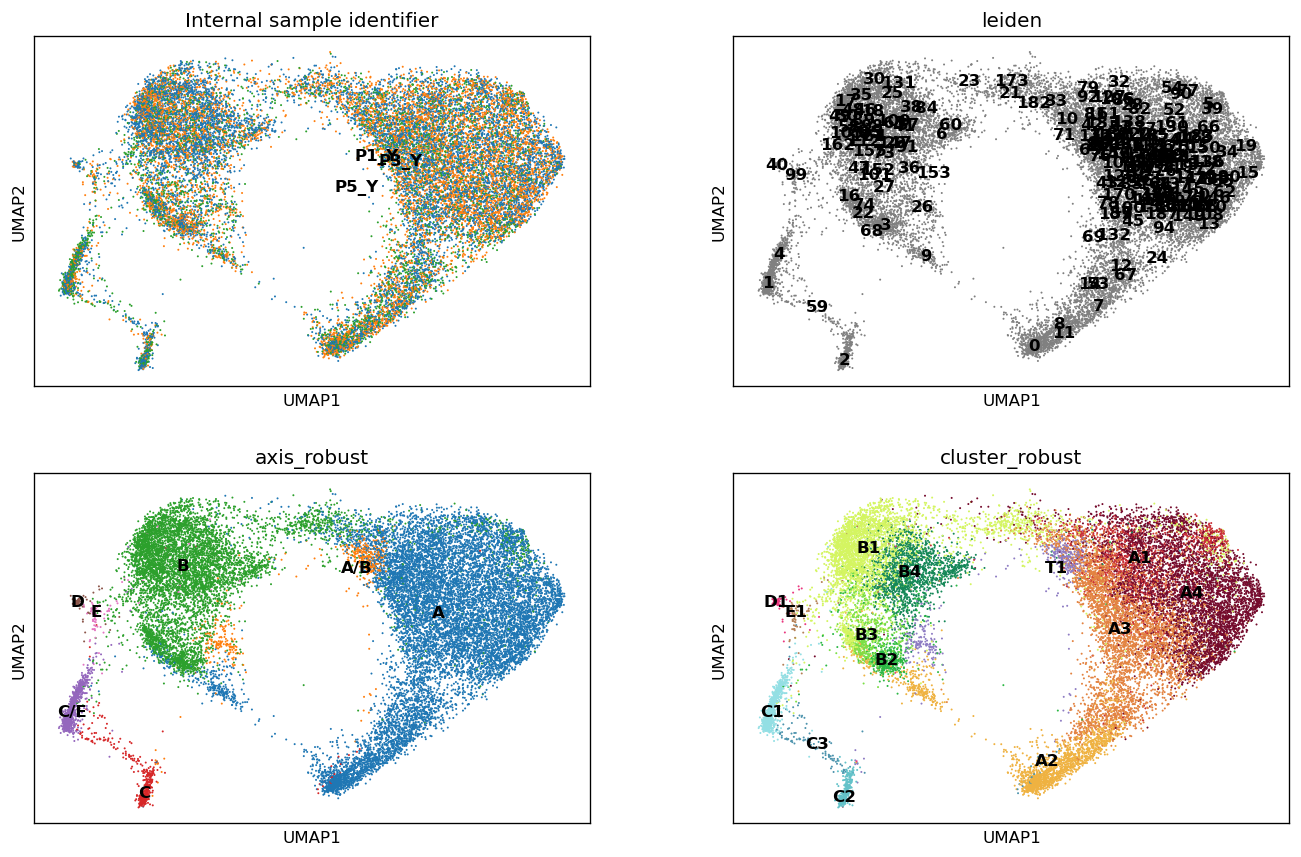

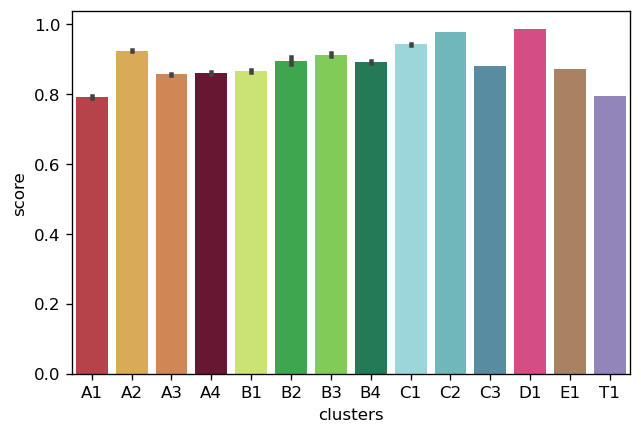

In [33]:
assign_cats(ahlers_2022_young_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.8, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(ahlers_2022_young_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

ahlers_2022_young_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(ahlers_2022_young_fb.obs['cluster_robust']))]
sc.pl.umap(ahlers_2022_young_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(ahlers_2022_young_fb, cluster_column='cluster_robust')
ahlers_2022_young_fb.write_h5ad(ahlers_2022_dir + '/ahlers_2022_young_fb_robust.h5')

### Boothby 2021

... storing 'cluster_robust' as categorical
... storing 'axis_robust' as categorical


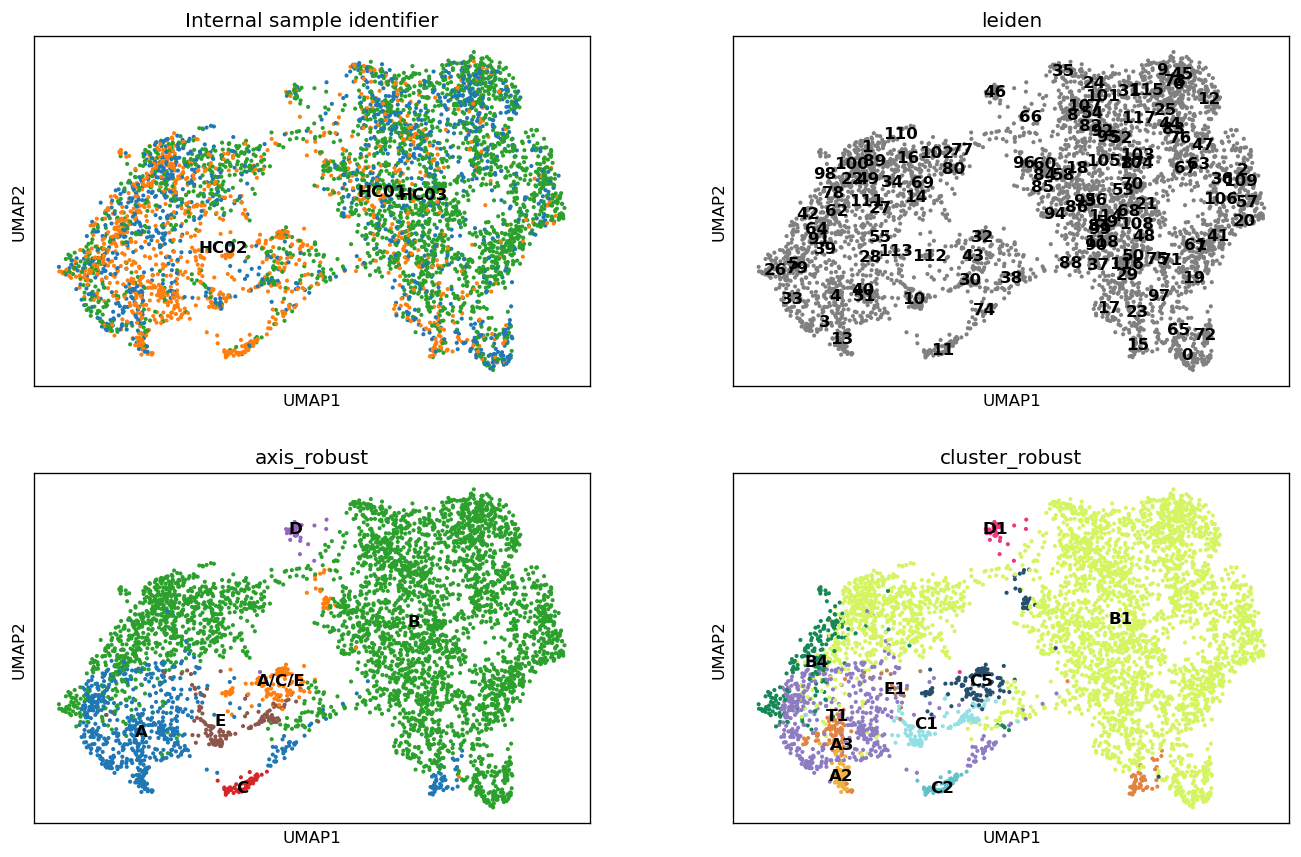

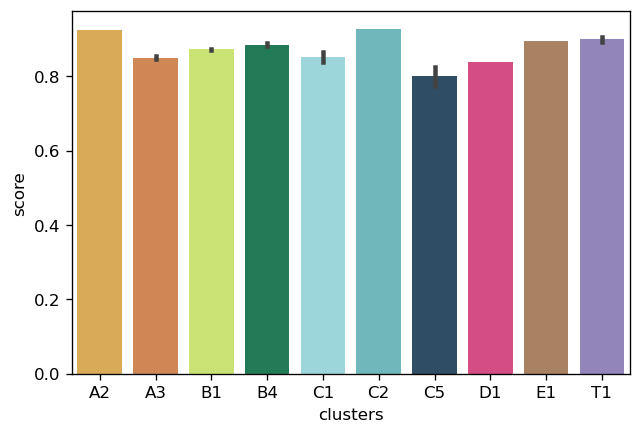

In [34]:
assign_cats(boothby_2021_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.95, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(boothby_2021_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

boothby_2021_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(boothby_2021_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(boothby_2021_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(boothby_2021_ctrl_fb, cluster_column='cluster_robust')
boothby_2021_ctrl_fb.write_h5ad(boothby_2021_dir + '/boothby_2021_ctrl_fb_robust.h5')

### Deng 2021

In [ ]:
assign_cats(deng_2021_scar_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.99, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(deng_2021_scar_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

deng_2021_scar_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(deng_2021_scar_fb.obs['cluster_robust']))]
sc.pl.umap(deng_2021_scar_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(deng_2021_scar_fb, cluster_column='cluster_robust')
deng_2021_scar_fb.write_h5ad(deng_2021_dir + '/deng_2021_scar_fb_robust.h5')

### Gao 2021

In [ ]:
assign_cats(gao_2021_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.8, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(gao_2021_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

gao_2021_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(gao_2021_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(gao_2021_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(gao_2021_ctrl_fb, cluster_column='cluster_robust')
gao_2021_ctrl_fb.write_h5ad(gao_2021_dir + '/gao_2021_ctrl_fb_robust.h5')

### Gaydosik 2020

In [ ]:
assign_cats(gaydosik_2020_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.9, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(gaydosik_2020_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

gaydosik_2020_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(gaydosik_2020_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(gaydosik_2020_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(gaydosik_2020_ctrl_fb, cluster_column='cluster_robust')
gaydosik_2020_ctrl_fb.write_h5ad(gaydosik_2020_dir + '/gaydosik_2020_ctrl_fb_robust.h5')

### He 2020

In [ ]:
assign_cats(he_2020_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.9, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(he_2020_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

he_2020_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(he_2020_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(he_2020_ctrl_fb, color=['Internal sample identifier', 'leiden', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(he_2020_ctrl_fb, cluster_column='cluster_robust')
he_2020_ctrl_fb.write_h5ad(he_2020_dir + '/he_2020_ctrl_fb_robust.h5')

### Hughes 2020

In [ ]:
assign_cats(hughes_2020_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.75, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(hughes_2020_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)
hughes_2020_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(hughes_2020_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(hughes_2020_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(hughes_2020_ctrl_fb, cluster_column='cluster_robust')
hughes_2020_ctrl_fb.write_h5ad(hughes_2020_dir + '/hughes_2020_ctrl_fb_robust.h5')

### Kim 2020

In [ ]:
assign_cats(kim_2020_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.85, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(kim_2020_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

kim_2020_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(kim_2020_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(kim_2020_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(kim_2020_ctrl_fb, cluster_column='cluster_robust')
kim_2020_ctrl_fb.write_h5ad(kim_2020_dir + '/kim_2020_ctrl_fb_robust.h5')

### Kim 2021

In [ ]:
assign_cats(kim_2021_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.9, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(kim_2021_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

kim_2021_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(kim_2021_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(kim_2021_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(kim_2021_ctrl_fb, cluster_column='cluster_robust')
kim_2021_ctrl_fb.write_h5ad(kim_2021_dir + '/kim_2021_ctrl_fb_robust.h5')

### Liu 2021

In [ ]:
assign_cats(liu_2021_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.75, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(liu_2021_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

liu_2021_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(liu_2021_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(liu_2021_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(liu_2021_ctrl_fb, cluster_column='cluster_robust')
liu_2021_ctrl_fb.write_h5ad(liu_2021_dir + '/liu_2021_ctrl_fb_robust.h5')

### Mariottoni 2021

In [ ]:
assign_cats(mariottoni_2021_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.9, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(mariottoni_2021_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

mariottoni_2021_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(mariottoni_2021_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(mariottoni_2021_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(mariottoni_2021_ctrl_fb, cluster_column='cluster_robust')
mariottoni_2021_ctrl_fb.write_h5ad(mariottoni_2021_dir + '/mariottoni_2021_ctrl_fb_robust.h5')

### Mirizio 2020

In [ ]:
assign_cats(mirizio_2020_scl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.9, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(mirizio_2020_scl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

mirizio_2020_scl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(mirizio_2020_scl_fb.obs['cluster_robust']))]
sc.pl.umap(mirizio_2020_scl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(mirizio_2020_scl_fb, cluster_column='cluster_robust')
mirizio_2020_scl_fb.write_h5ad(mirizio_2020_dir + '/mirizio_2020_scl_fb_robust.h5')

### Reynolds 2021

In [ ]:
assign_cats(reynolds_2021_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.9, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(reynolds_2021_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', quantile_gene_sel=0.85,
            intermediate_states=True, diff=0.15, others_name='U', verbose=False)

reynolds_2021_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(reynolds_2021_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(reynolds_2021_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(reynolds_2021_ctrl_fb, cluster_column='cluster_robust')
reynolds_2021_ctrl_fb.write_h5ad(reynolds_2021_dir + '/reynolds_2021_ctrl_fb_robust.h5')

### Rindler 2021

In [ ]:
assign_cats(rindler_2021_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.9, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(rindler_2021_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

rindler_2021_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(rindler_2021_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(rindler_2021_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(rindler_2021_ctrl_fb, cluster_column='cluster_robust')
rindler_2021_ctrl_fb.write_h5ad(rindler_2021_dir + '/rindler_2021_ctrl_fb_robust.h5')

### Solé-Boldo 2021

In [ ]:
assign_cats(sole_2020_young_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.8, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(sole_2020_young_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

sole_2020_young_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(sole_2020_young_fb.obs['cluster_robust']))]
sc.pl.umap(sole_2020_young_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(sole_2020_young_fb, cluster_column='cluster_robust')
sole_2020_young_fb.write_h5ad(sole_2020_dir + '/sole_2020_young_fb_robust.h5')

### Tabib 2018

In [ ]:
assign_cats(tabib_2018_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.85, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(tabib_2018_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

tabib_2018_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(tabib_2018_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(tabib_2018_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(tabib_2018_ctrl_fb, cluster_column='cluster_robust')
tabib_2018_ctrl_fb.write_h5ad(tabib_2018_dir + '/tabib_2018_ctrl_fb_robust.h5')

### Tabib 2021

In [ ]:
assign_cats(tabib_2021_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.8, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(tabib_2021_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

tabib_2021_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(tabib_2021_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(tabib_2021_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(tabib_2021_ctrl_fb, cluster_column='cluster_robust')
tabib_2021_ctrl_fb.write_h5ad(tabib_2021_dir + '/tabib_2021_ctrl_fb_robust.h5')

### Theocarditis 2020

In [ ]:
assign_cats(theo_2020_ctrl_dm_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.9, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(theo_2020_ctrl_dm_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

theo_2020_ctrl_dm_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(theo_2020_ctrl_dm_fb.obs['cluster_robust']))]
sc.pl.umap(theo_2020_ctrl_dm_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(theo_2020_ctrl_dm_fb, cluster_column='cluster_robust')
theo_2020_ctrl_dm_fb.write_h5ad(theo_2020_dir + '/theo_2020_ctrl_dm_fb_robust.h5')

### Theocarditis 2021

In [ ]:
assign_cats(theo_2021_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.7, 
            key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(theo_2021_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4,  key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

theo_2021_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(theo_2021_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(theo_2021_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(theo_2021_ctrl_fb, cluster_column='cluster_robust')
theo_2021_ctrl_fb.write_h5ad(theo_2021_dir + '/theo_2021_ctrl_fb_robust.h5')

### Vorstandlechner 2020

In [ ]:
assign_cats(vors_2020_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.5, quantile_gene_sel=0.95, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(vors_2020_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

vors_2020_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(vors_2020_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(vors_2020_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(vors_2020_ctrl_fb, cluster_column='cluster_robust')
vors_2020_ctrl_fb.write_h5ad(vors_2020_dir + '/vors_2020_ctrl_fb_robust.h5')

### Xu 2021

In [ ]:
assign_cats(xu_2021_ctrl_fb, dict_cats=dict_cats_clusters_robust, min_score=0.45, quantile_gene_sel=0.7, key_added='cluster_robust', others_name='U', verbose=False)
assign_cats(xu_2021_ctrl_fb, column_groupby='cluster_robust', dict_cats=dict_cats_axes_robust, min_score=0.4, key_added='axis_robust', 
            quantile_gene_sel=0.95, intermediate_states=True, diff=0.05, others_name='U', verbose=False)

xu_2021_ctrl_fb.uns['cluster_robust_colors'] = [dict_colors[i] if i in dict_colors else '#bcbcbc' for i in sorted(set(xu_2021_ctrl_fb.obs['cluster_robust']))]
sc.pl.umap(xu_2021_ctrl_fb, color=['Internal sample identifier', 'leiden', 'axis_robust', 'cluster_robust'], legend_loc='on data', cmap=magma, use_raw=False, ncols=2)
plot_score_graph(xu_2021_ctrl_fb, cluster_column='cluster_robust')
xu_2021_ctrl_fb.write_h5ad(xu_2021_dir + '/xu_2021_ctrl_fb_robust.h5')

## Reevaluate the presence of clusters for each dataset

In [ ]:
list_all_datasets = [ahlers_2022_young_fb, boothby_2021_ctrl_fb, 
                     deng_2021_scar_fb, gao_2021_ctrl_fb, gaydosik_2020_ctrl_fb, 
                     he_2020_ctrl_fb, hughes_2020_ctrl_fb, kim_2020_ctrl_fb, 
                     liu_2021_ctrl_fb, mariottoni_2021_ctrl_fb,
                     mirizio_2020_scl_fb, reynolds_2021_ctrl_fb, rindler_2021_ctrl_fb,
                     sole_2020_young_fb, tabib_2018_ctrl_fb, tabib_2021_ctrl_fb,
                     theo_2020_ctrl_dm_fb, theo_2021_ctrl_fb,
                     vors_2020_ctrl_fb, xu_2021_ctrl_fb]

list_names = [adata.obs['Author'].values[0] + ' ' + str(int(adata.obs['Year'].values[0])) for adata in list_all_datasets]

In [ ]:
%store list_all_datasets
%store list_datasets

%store list_accepted_clusters
%store list_accepted_axis
%store list_names

In [ ]:
plot_adata_cluster_properties(dict_cats_clusters=dict_cats_clusters_robust, list_datasets=list_all_datasets, what='presence', cluster_name='cluster_robust', axis_name='axis_robust')

In [ ]:
plot_adata_cluster_properties(dict_cats_clusters=dict_cats_clusters_robust, list_datasets=list_all_datasets, what='percentage', cluster_name='cluster_robust', axis_name='axis_robust')

In [ ]:
plot_adata_cluster_properties(dict_cats_clusters=dict_cats_clusters_robust, list_datasets=list_all_datasets, what='axis', cluster_name='cluster_robust', axis_name='axis_robust')

## Plotting all Adatas

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(5 * 4, 4 * 4))

for ax in axs.ravel()[len(list_all_datasets) - len(axs) :]:
    ax.set_axis_off()

for adata, name, idx in zip(list_all_datasets, list_names, range(len(list_all_datasets))):
    sc.pl.umap(adata, color=['cluster_robust'], legend_loc='on data', show=False, ax = axs.ravel()[idx], 
               title=str(adata.obs['Author'].iloc[0]) + ' ' + str(int(adata.obs['Year'].iloc[0])), size=15, cmap=magma, frameon=False)

## PAGA 

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(5 * 4, 4 * 4))

for ax in axs.ravel():
    ax.set_axis_off()
    
for adata, name, idx in zip(list_all_datasets, list_names, range(len(list_all_datasets))):
    sc.tl.paga(adata, groups='cluster_robust')
    sc.pl.paga(adata, ax=axs.ravel()[idx], frameon=False, show=False, 
               title=str(adata.obs['Author'].iloc[0]) + ' ' + str(int(adata.obs['Year'].iloc[0])))

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(5 * 4, 4 * 4))

for ax in axs.ravel()[len(list_all_datasets) - len(axs) :]:
    ax.set_axis_off()
    
for adata, name, idx in zip(list_all_datasets, list_names, range(len(list_all_datasets))):
    sc.tl.paga(adata, groups='cluster_robust')
    sc.pl.paga(adata, ax=axs.ravel()[idx], frameon=False, show=False, solid_edges='connectivities_tree', 
               title=str(adata.obs['Author'].iloc[0]) + ' ' + str(int(adata.obs['Year'].iloc[0])))

## Combined PAGA 

### Using connectivities_tree

In [ ]:
df_all = pd.DataFrame(0, index=list_accepted_clusters + ['U'], columns=list_accepted_clusters + ['U'])

for adata in tqdm(list_all_datasets):
    dfsub = pd.DataFrame(adata.uns['paga']['connectivities_tree'].todense(), 
                  columns=adata.obs['cluster_robust'].cat.categories, 
                  index=adata.obs['cluster_robust'].cat.categories)
    
    df_all.loc[dfsub.index, dfsub.index] = df_all.loc[dfsub.index, dfsub.index] + dfsub
    
df_all = df_all.iloc[:-2, :-2] # To remove U and T1

df_all[df_all < 1] = 0
df_all = df_all ** 1.25

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
G = nx.convert_matrix.from_pandas_adjacency(df_all)
pos=nx.spring_layout(G, seed=7)

edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw_networkx(G, pos, width=weights, node_color=[dict_colors[i] for i in df_all.index], ax=ax)
plt.axis('off')

### Using connectivities

In [ ]:
df_all = pd.DataFrame(0, index=list_accepted_clusters + ['U'], columns=list_accepted_clusters + ['U'])

for adata in list_all_datasets:
    dfsub = pd.DataFrame(adata.uns['paga']['connectivities'].todense(), 
                  columns=adata.obs['cluster_robust'].cat.categories, 
                  index=adata.obs['cluster_robust'].cat.categories)
    
    df_all.loc[dfsub.index, dfsub.index] = df_all.loc[dfsub.index, dfsub.index] + dfsub
    
df_all = df_all.iloc[:-1, :-1] # To remove U

df_all[df_all < 2.3] = 0
df_all = df_all

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
G = nx.convert_matrix.from_pandas_adjacency(df_all)
pos=nx.spring_layout(G, seed=1)

edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw_networkx(G, pos, width=weights, node_color=[dict_colors[i] for i in df_all.index])
plt.axis('off')